## Flattening the dataset 

In [8]:
import os
import shutil
from tqdm import tqdm

def flatten_dataset_structure(base_path):
    # Paths to leftImg8bit and gtFine
    leftimg8bit_path = os.path.join(base_path, 'leftImg8bit')
    gtfine_path = os.path.join(base_path, 'gtFine')

    # Flatten leftImg8bit
    for split in ['train', 'val', 'test']:
        src_split_path = os.path.join(leftimg8bit_path, split)
        if not os.path.exists(src_split_path):
            continue

        print(f"Flattening leftImg8bit/{split}...")
        for city_folder in tqdm(os.listdir(src_split_path)):
            city_path = os.path.join(src_split_path, city_folder)
            if os.path.isdir(city_path):
                for file in os.listdir(city_path):
                    src_file = os.path.join(city_path, file)
                    dest_file = os.path.join(src_split_path, file)
                    shutil.move(src_file, dest_file)
                os.rmdir(city_path)

    # Flatten gtFine
    for split in ['train', 'val']:
        src_split_path = os.path.join(gtfine_path, split)
        if not os.path.exists(src_split_path):
            continue

        print(f"Flattening gtFine/{split}...")
        for city_folder in tqdm(os.listdir(src_split_path)):
            city_path = os.path.join(src_split_path, city_folder)
            if os.path.isdir(city_path):
                for file in os.listdir(city_path):
                    src_file = os.path.join(city_path, file)
                    dest_file = os.path.join(src_split_path, file)
                    shutil.move(src_file, dest_file)
                os.rmdir(city_path)

    print("Dataset structure flattened successfully.")

# Usage:
flatten_dataset_structure(r"C:\Users\Sejal Hanmante\Downloads\IDD_Segmentation")


Flattening leftImg8bit/train...


100%|██████████| 6906/6906 [00:00<00:00, 22879.45it/s]


Flattening leftImg8bit/val...


100%|██████████| 979/979 [00:00<00:00, 24716.34it/s]


Flattening leftImg8bit/test...


100%|██████████| 2023/2023 [00:00<00:00, 24992.57it/s]


Flattening gtFine/train...


100%|██████████| 6906/6906 [00:00<00:00, 14499.95it/s]


Flattening gtFine/val...


100%|██████████| 979/979 [00:00<00:00, 14529.13it/s]

Dataset structure flattened successfully.


In [12]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Set parameters
im_width = 1024
im_height = 1024

def create_multiclass_mask(data, label_map=None):
    if label_map is None:
        label_map = {}

    w = data["imgWidth"]
    h = data["imgHeight"]
    mask = np.zeros((h, w), dtype=np.uint8)  # height, width

    for obj in data["objects"]:
        label = obj["label"]
        polygon = obj["polygon"]

        # Ensure the polygon is a list of (x, y) tuples
        polygon = [(int(p[0]), int(p[1])) for p in polygon]

        if label not in label_map:
            label_map[label] = len(label_map) + 1  # Reserve 0 for background

        class_idx = label_map[label]

        img = Image.new("L", (w, h), 0)
        draw = ImageDraw.Draw(img)
        draw.polygon(polygon, outline=class_idx, fill=class_idx)

        mask += np.array(img, dtype=np.uint8)

    return mask, label_map





Unique labels found: dict_keys(['road', 'sky', 'drivable fallback', 'motorcycle', 'building', 'obs-str-bar-fallback', 'vegetation', 'pole', 'vehicle fallback', 'person', 'rider', 'billboard', 'traffic sign', 'car'])


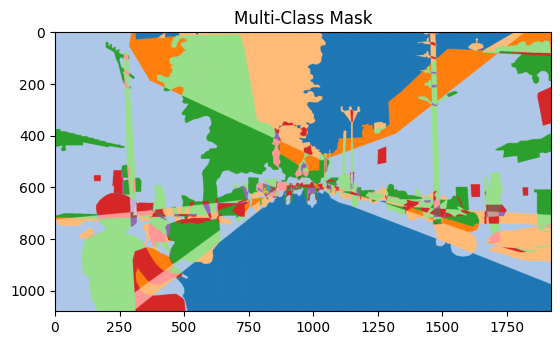

In [13]:
with open(r"C:\Users\Sejal Hanmante\Downloads\IDD_Segmentation\gtFine\train\000128_gtFine_polygons.json", "r") as f:
    data = json.load(f)

mask, label_map = create_multiclass_mask(data)

print("Unique labels found:", label_map.keys())
plt.imshow(mask, cmap="tab20")
plt.title("Multi-Class Mask")
plt.show()


In [ ]:
import os
import json
import torch
import numpy as np
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split

# --- Transforms ---
transform_img = transforms.Compose([
    transforms.Resize((512, 1024)),  # Resize for training
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize((512, 1024), interpolation=Image.NEAREST),
    transforms.PILToTensor()
])

# --- Create Mask from Polygon JSON ---
def create_multiclass_mask(data, label_map):
    size = tuple(data['imgWidth'], data['imgHeight'])
    mask = Image.new("L", size, 0)
    draw = ImageDraw.Draw(mask)

    for obj in data['objects']:
        label = obj['label']
        if label not in label_map:
            label_map[label] = len(label_map) + 1  # class index starts from 1
        draw.polygon([tuple(p) for p in obj['polygon']], fill=label_map[label])

    return np.array(mask), label_map

# --- Custom Dataset Class ---
class IDDSegmentationDataset(Dataset):
    def __init__(self, leftimg_dir, gtfine_dir, file_list):
        self.leftimg_dir = leftimg_dir
        self.gtfine_dir = gtfine_dir
        self.file_list = file_list
        self.label_map = {}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file = self.file_list[idx]
        img_path = os.path.join(self.leftimg_dir, file)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform_img(img)

        file_id = file.replace("_leftImg8bit.png", "")
        json_file = os.path.join(self.gtfine_dir, file_id + "_gtFine_polygons.json")

        with open(json_file, "r") as f:
            data = json.load(f)

        mask_np, self.label_map = create_multiclass_mask(data, self.label_map)
        mask_img = Image.fromarray(mask_np)
        mask_tensor = transform_mask(mask_img).squeeze(0)

        return img_tensor, mask_tensor.long()

# --- Get File List from Flattened Directory ---
def get_file_list(flattened_img_dir, split='train'):
    split_path = os.path.join(flattened_img_dir, split)
    return [file for file in os.listdir(split_path) if file.endswith("_leftImg8bit.png")]

# --- Paths ---
leftimg_root = r"C:\Users\Sejal Hanmante\Downloads\IDD_Segmentation\leftImg8bit"
gtfine_root = r"C:\Users\Sejal Hanmante\Downloads\IDD_Segmentation\gtFine"
split = 'train'

# --- Get file list and split indices ---
all_files = get_file_list(leftimg_root, split)
train_idx, val_idx = train_test_split(np.arange(len(all_files)), test_size=0.2, random_state=42)

# --- Dataset Initialization ---
train_dataset = IDDSegmentationDataset(
    os.path.join(leftimg_root, split),
    os.path.join(gtfine_root, split),
    all_files
)

# --- Samplers and Dataloaders ---
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=4, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(train_dataset, batch_size=4, sampler=val_sampler, num_workers=2)

# --- Check a Batch ---
for imgs, masks in train_loader:
    print("Image Batch:", imgs.shape)   # [B, 3, H, W]
    print("Mask Batch:", masks.shape)   # [B, H, W]
    break


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

# Choose a random sample index from the train dataset
ix = random.randint(0, len(train_dataset) - 1)

# Get image and mask from dataset
img_tensor, mask_tensor = train_dataset[ix]  # (C, H, W), (H, W)
img_np = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
mask_np = mask_tensor.numpy()                # (H, W)

# Check if mask contains any labeled pixels
has_mask = mask_np.max() > 0

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Image
ax[0].imshow(img_np)
if has_mask:
    ax[0].contour(mask_np, colors='red', levels=[0.5])
ax[0].set_title('Image with Mask Contour', fontsize=16)
ax[0].axis('off')

# Mask
cmap = plt.get_cmap('tab20')  # Colorful colormap for multi-class
ax[1].imshow(mask_np, cmap=cmap, interpolation='nearest')
ax[1].set_title('Segmentation Mask (Multi-class)', fontsize=16)
ax[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch.nn as nn
class depthwise_separable_block(nn.Module):
    def __init__(self, in_channels, out_channels, batchnorm=True):
        super(depthwise_separable_block, self).__init__()

        layers = [
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels),  # Depthwise
            nn.Conv2d(in_channels, out_channels, kernel_size=1),  # Pointwise
        ]

        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=4, n_filters=16, dropout=0.5, batchnorm=True):
        super(UNet, self).__init__()

        self.encoder1 = depthwise_separable_block(in_channels, n_filters, batchnorm=batchnorm)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(dropout * 0.5)

        self.encoder2 = depthwise_separable_block(n_filters, n_filters * 2, batchnorm=batchnorm)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(dropout)

        self.encoder3 = depthwise_separable_block(n_filters * 2, n_filters * 4, batchnorm=batchnorm)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(dropout)

        self.encoder4 = depthwise_separable_block(n_filters * 4, n_filters * 8, batchnorm=batchnorm)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout4 = nn.Dropout(dropout)

        self.bottleneck = depthwise_separable_block(n_filters * 8, n_filters * 16, batchnorm=batchnorm)

        self.upconv6 = nn.ConvTranspose2d(n_filters * 16, n_filters * 8, 2, stride=2)
        self.decoder6 = depthwise_separable_block(n_filters * 16, n_filters * 8, batchnorm=batchnorm)

        self.upconv7 = nn.ConvTranspose2d(n_filters * 8, n_filters * 4, 2, stride=2)
        self.decoder7 = depthwise_separable_block(n_filters * 8, n_filters * 4, batchnorm=batchnorm)

        self.upconv8 = nn.ConvTranspose2d(n_filters * 4, n_filters * 2, 2, stride=2)
        self.decoder8 = depthwise_separable_block(n_filters * 4, n_filters * 2, batchnorm=batchnorm)

        self.upconv9 = nn.ConvTranspose2d(n_filters * 2, n_filters, 2, stride=2)
        self.decoder9 = depthwise_separable_block(n_filters * 2, n_filters, batchnorm=batchnorm)

        self.final_conv = nn.Conv2d(n_filters, num_classes, kernel_size=1)

    def forward(self, x):
        c1 = self.encoder1(x)
        p1 = self.dropout1(self.pool1(c1))

        c2 = self.encoder2(p1)
        p2 = self.dropout2(self.pool2(c2))

        c3 = self.encoder3(p2)
        p3 = self.dropout3(self.pool3(c3))

        c4 = self.encoder4(p3)
        p4 = self.dropout4(self.pool4(c4))

        c5 = self.bottleneck(p4)

        u6 = self.upconv6(c5)
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.decoder6(u6)

        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.decoder7(u7)

        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.decoder8(u8)

        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.decoder9(u9)

        return self.final_conv(c9)


In [ ]:
# Finding the number of segmentation mask classes
mask, label_map = create_multiclass_mask(data)

unique_classes = np.unique(mask)
num_classes = len(unique_classes)

print("Unique class IDs in mask:", unique_classes)
print("Number of segmentation classes:", num_classes)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

# Define image dimensions and number of classes
im_height, im_width = 256, 256
in_channels = 3
num_classes = len(unique_classes)  # From np.unique(mask)

# Instantiate the model
model = UNet(
    in_channels=in_channels,
    num_classes=num_classes,
    n_filters=16,
    dropout=0.05,
    batchnorm=True
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Model summary
summary(model, input_size=(in_channels, im_height, im_width))

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()  # No softmax needed on output

# Sanity check: dummy input
x = torch.randn(1, in_channels, im_height, im_width).to(device)
y = model(x)
print("Output shape:", y.shape)  # Should be [1, num_classes, H, W]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# ------------------ Dice & IoU Metrics ------------------
def dice_score(pred, target, num_classes):
    dice = []
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    for c in range(num_classes):
        pred_c = (pred == c).astype(np.uint8)
        target_c = (target == c).astype(np.uint8)
        intersection = np.sum(pred_c * target_c)
        union = np.sum(pred_c) + np.sum(target_c)
        if union == 0:
            dice.append(1.0)
        else:
            dice.append((2. * intersection) / union)
    return np.mean(dice)

def iou_score(pred, target, num_classes):
    iou = []
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    for c in range(num_classes):
        pred_c = (pred == c).astype(np.uint8)
        target_c = (target == c).astype(np.uint8)
        intersection = np.sum(pred_c * target_c)
        union = np.sum(pred_c) + np.sum(target_c) - intersection
        if union == 0:
            iou.append(1.0)
        else:
            iou.append(intersection / union)
    return np.mean(iou)

In [ ]:
# ------------------ Model Setup ------------------
im_height, im_width = 256, 256
in_channels = 3
num_classes = len(unique_classes)  # Must be defined beforehand

model = UNet(in_channels=in_channels, num_classes=num_classes, n_filters=16, dropout=0.05, batchnorm=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# ------------------ Optimizer, Loss, Scheduler ------------------
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-5, verbose=True)

# ------------------ Training Loop ------------------
best_model_path = "model_best.pth"
early_stopping_patience = 10
best_val_loss = float("inf")
epochs_without_improvement = 0
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    with tqdm(train_loader, desc=f"\U0001f501 Epoch {epoch+1}/{num_epochs} [Training]") as pbar:
        for img, mask in pbar:
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, mask.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

    model.eval()
    val_loss = 0.0
    dice_total = 0.0
    iou_total = 0.0
    with torch.no_grad():
        for img, mask in tqdm(val_loader, desc="🦚 Validation"):
            img, mask = img.to(device), mask.to(device)
            output = model(img)
            loss = criterion(output, mask.long())
            val_loss += loss.item()

            preds = torch.argmax(output, dim=1)
            dice_total += dice_score(preds, mask, num_classes)
            iou_total += iou_score(preds, mask, num_classes)

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    mean_dice = dice_total / len(val_loader)
    mean_iou = iou_total / len(val_loader)

    print(f"\U0001f4d8 Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Dice={mean_dice:.4f}, IoU={mean_iou:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("✅ Saved best model")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print("⏹️ Early stopping triggered")
        break


In [ ]:
# ------------------ Save Predictions & Visualizations ------------------
def save_predictions(model, test_loader, save_folder="predictions"):
    os.makedirs(save_folder, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for i, (img, mask) in enumerate(tqdm(test_loader, desc="🦚 Test Inference")):
            img = img.to(device)
            output = model(img)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
            gt = mask.squeeze(0).cpu().numpy()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(TF.to_pil_image(img.squeeze(0).cpu()))
            axs[0].set_title("Input Image")
            axs[1].imshow(gt, cmap="nipy_spectral")
            axs[1].set_title("Ground Truth")
            axs[2].imshow(pred, cmap="nipy_spectral")
            axs[2].set_title("Prediction")
            for ax in axs: ax.axis('off')
            plt.tight_layout()
            plt.savefig(f"{save_folder}/sample_{i}.png")
            plt.close()

# Call this after training:
save_predictions(model, val_loader)